<a href="https://colab.research.google.com/github/H0SS4M/Head-Pose-Estemation/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing MediaPipe

In [4]:
%%capture
!pip install mediapipe

### Required Libraries

In [5]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

In [6]:
import matplotlib.pyplot as plt

### Dowlining Data

In [7]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [8]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [9]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

### Preparing Data

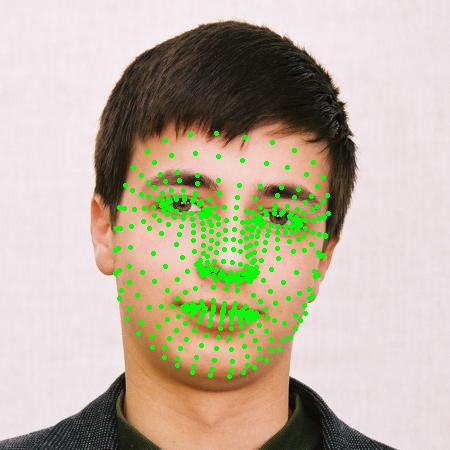

468
468


In [91]:
# choosing random image
random_file = 'image00060'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      x_list = []
      y_list = []
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              #cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
              x_list.append(relative_x)
              y_list.append(relative_y)
      
      cv2_imshow(image)
      print(len(x_list))
      print(len(y_list))

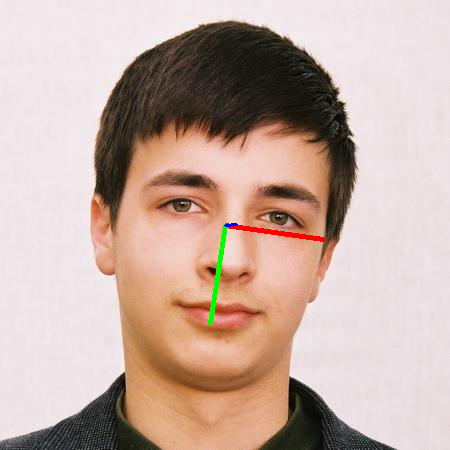

In [93]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch1 = pose_para[0]
yaw1 = pose_para[1]
roll1 = pose_para[2]
cv2_imshow(draw_axis(image,pitch1,yaw1,roll1))

## Read all the points in the dataset

In [12]:
file_names = sorted([Path(f).stem for f in glob.glob('/content/AFLW2000/*.mat')])

faceModule = mediapipe.solutions.face_mesh
X_x = []
X_y = []
# labels
pitch = []
yaw = []
roll = []

for file_name in file_names:
    with faceModule.FaceMesh(static_image_mode=True) as faces:
      
        # loading the image and the mat file
        image = cv2.imread('/content/AFLW2000/'+file_name+'.jpg')

        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
          mat_file = sio.loadmat('/content/AFLW2000/'+file_name+'.mat')
          # looping over the faces in the image
          face =  results.multi_face_landmarks[0]
          x_list = []
          y_list = []
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              
              x_list.append(relative_x)
              y_list.append(relative_y)
          
          # features
          X_x.append(x_list)
          X_y.append(y_list)

          # labels
          pose_para = mat_file["Pose_Para"][0][:3]
          pitch.append(pose_para[0])
          yaw.append(pose_para[1])
          roll.append(pose_para[2])
        
        #cv2_imshow(image)
    

In [13]:
print(len(X_x))
print(len(X_y))
print(len(pitch))
print(len(yaw))
print(len(roll))

1853
1853
1853
1853
1853


In [14]:
x_np = np.array(X_x)
y_np = np.array(X_y)
x_np

array([[218, 220, 220, ..., 243, 299, 304],
       [198, 187, 201, ..., 225, 263, 267],
       [143, 144, 143, ..., 147, 168, 169],
       ...,
       [263, 271, 267, ..., 292, 330, 334],
       [221, 225, 223, ..., 247, 303, 308],
       [232, 231, 230, ..., 240, 283, 287]])

## Now we Have the DATA X has 936 fetureas and Y has 3 labels

# Let's normalize The DATA

In [15]:
# Center 
x_np_center = x_np - x_np[:,122].reshape(-1, 1)
y_np_center = y_np - y_np[:,122].reshape(-1, 1)

In [16]:
# Norm on y scale
x_np_norm = x_np_center / (x_np[:,171].reshape(-1, 1) - x_np_center[:,9].reshape(-1, 1))
y_np_norm = y_np_center / (y_np[:,171].reshape(-1, 1) - x_np_center[:,9].reshape(-1, 1))

## Features

In [17]:
Xs = pd.DataFrame(x_np_norm)
Ys = pd.DataFrame(y_np_norm)
X = pd.concat([Xs, Ys], axis=1)
X.columns = [i for i in range(936)]
X.head()

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,0.005376,0.016129,0.016129,-0.010753,0.016129,0.026882,0.048387,-0.290323,0.059140,0.064516,...,0.170455,0.161932,0.164773,0.173295,0.176136,-0.028409,-0.019886,-0.008523,-0.045455,-0.056818
1,-0.044118,-0.098039,-0.029412,-0.053922,-0.098039,-0.073529,0.004902,0.004902,0.029412,0.024510,...,0.116923,0.113846,0.132308,0.120000,0.126154,-0.009231,-0.003077,0.000000,-0.018462,-0.027692
2,0.038462,0.046154,0.038462,0.007692,0.046154,0.046154,0.030769,-0.207692,0.023077,0.023077,...,0.059585,0.056995,0.056995,0.062176,0.062176,-0.007772,-0.005181,-0.002591,-0.015544,-0.018135
3,0.113821,0.052846,0.089431,0.004065,0.036585,0.028455,0.020325,-0.146341,-0.008130,-0.024390,...,0.128767,0.117808,0.109589,0.134247,0.134247,-0.052055,-0.041096,-0.030137,-0.106849,-0.120548
4,0.101770,0.066372,0.079646,0.017699,0.057522,0.048673,0.030973,-0.199115,0.017699,0.008850,...,0.128767,0.117808,0.128767,0.131507,0.136986,-0.027397,-0.019178,-0.013699,-0.063014,-0.068493


## Labels

In [18]:
# convert the lists into df
Y = {'pitch': pitch, 'yaw': yaw, 'roll': roll}
Y = pd.DataFrame(Y)
Y.head()

,pitch,yaw,roll
0,-0.399231,0.018227,0.085676
1,0.470065,1.189533,0.300959
2,-0.184650,0.881137,-0.236852
3,-0.175379,0.299208,-0.373374
4,-0.026812,0.011965,-0.220662


## Now will use GridSearch to see the best param for the model
## for every label

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# List of models for every label
models = []
parameters = {'kernel':('rbf', 'linear'), 'C':[1, 10]}

for i in range(3):
    model = GridSearchCV(SVR(), parameters, cv = 5, n_jobs = -1, verbose = 1)
    model.fit(X, Y.iloc[:,i])
    models.append(model)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [20]:
from sklearn.metrics import mean_absolute_error

In [21]:
#pitch
pitch_model = models[0].best_estimator_.fit(X, Y.iloc[:,0])
print('r2_score:', pitch_model.score(X, Y.iloc[:,0]))
print('mean_absolute_error:', mean_absolute_error(pitch_model.predict(X), Y.iloc[:,0]))

r2_score: 0.21533040175906826
mean_absolute_error: 0.0949377730471048


In [22]:
#yaw
yaw_model = models[1].best_estimator_.fit(X, Y.iloc[:,1])
print('r2_score:', yaw_model.score(X, Y.iloc[:,1]))
print('mean_absolute_error:', mean_absolute_error(yaw_model.predict(X), Y.iloc[:,1]))

r2_score: 0.8829763764781462
mean_absolute_error: 0.06866436878310284


In [23]:
#roll
roll_model = models[2].best_estimator_.fit(X, Y.iloc[:,2])
print('r2_score:', roll_model.score(X, Y.iloc[:,2]))
print('mean_absolute_error:', mean_absolute_error(roll_model.predict(X), Y.iloc[:,2]))

r2_score: 0.30745919287583556
mean_absolute_error: 0.0788884045277637


## Some functions to help in prediction

In [80]:
def normalize(x_np, y_np):
    # Center 
    x_np_center = x_np - x_np[122]
    y_np_center = y_np - y_np[122]
    # Norm on y scale
    x_np_norm = x_np_center / (x_np[171].reshape(-1, 1) - x_np_center[9].reshape(-1, 1))
    y_np_norm = y_np_center / (y_np[171].reshape(-1, 1) - x_np_center[9].reshape(-1, 1))
    return x_np_norm, y_np_norm

In [26]:
def to_dataframe(data):
    x_np_norm, y_np_norm = data[0], data[1]
    Xs = pd.DataFrame(x_np_norm)
    Ys = pd.DataFrame(y_np_norm)
    X = pd.concat([Xs, Ys], axis=1)
    X.columns = [i for i in range(936)]
    return X

In [27]:
def get_angels(X):
    pitch = pitch_model.predict(X)
    yaw = yaw_model.predict(X)
    roll = roll_model.predict(X)
    return pitch, yaw, roll

## Connect to drive to load the video

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
cap = cv2.VideoCapture('/content/drive/MyDrive/ml_porject/testing.mp4')
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video file")
else:
    print('succes')

succes


In [100]:
# capture the images
images = []
while(cap.isOpened()):
    ret, image = cap.read()
    images.append(image)
    if ret == False:
      break

## Let's go over every image and draw the axis on it

In [102]:
faceModule = mediapipe.solutions.face_mesh

for image in images[:-2]:
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          # looping over the faces in the image
          face =  results.multi_face_landmarks[0]
          x_list = []
          y_list = []
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              
              x_list.append(relative_x)
              y_list.append(relative_y)

          x_list = np.array(x_list)
          y_list = np.array(y_list)
          
          pitch, yaw, roll = get_angels(
              to_dataframe(
                  normalize(
                      x_list, y_list
                      )
                  )
              )
          draw_axis(image, pitch, yaw, roll, x_list[1], y_list[1])


In [106]:
cap.release()
# Closes all the frames
cv2.destroyAllWindows()

# converting the frames to video
out = cv2.VideoWriter('/content/drive/MyDrive/ml_porject/output/output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
for i in range(len(images)):
    out.write(images[i])
out.release()

In [107]:
# if u want to download the video
from google.colab import files
files.download('/content/drive/MyDrive/ml_porject/output/output.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>